In [1]:
%matplotlib inline

# ¿Que es torch.nn realmente?

PyTorch proporciona los módulos y clases elegantemente diseñados [``torch.nn``](https://pytorch.org/docs/stable/nn.html), [``torch.optim``](https://pytorch.org/docs/stable/optim.html), [``Dataset``](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) y [``DataLoader``](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) para ayudarlo a crear y entrenar redes neuronales. Para utilizar completamente su poder y personalizarlos para su problema, debe comprender realmente exactamente lo que están haciendo. Para desarrollar esta comprensión, primero entrenaremos la red neuronal básica en el conjunto de datos MNIST sin utilizar ninguna característica de estos modelos; Inicialmente, solo usaremos la funcionalidad de tensor de PyTorch más básica. A continuación, vamos a añadir de forma incremental una característica de ``torch.nn``, ``torch.optim``, ``Dataset``, o ``DataLoader`` en un momento, mostrando exactamente lo que hace cada pieza, y cómo funciona para que el código sea más concisa, o más flexible.

## Configuración de datos MNIST

Usaremos el conjunto de datos clásico [MNIST](http://deeplearning.net/data/mnist), que consiste en imágenes en blanco y negro de dígitos dibujados a mano (entre 0 y 9).

Usaremos [``pathlib``](https://docs.python.org/3/library/pathlib.html) para tratar con rutas (parte de la biblioteca estándar de Python 3) y descargaremos el conjunto de datos mediante [solicitudes](http://docs.python-requests.org/en/master). Solo importaremos módulos cuando los usemos, para que pueda ver exactamente lo que se está usando en cada punto.

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

Este conjunto de datos está en formato de matriz de numpy y se ha almacenado usando pickle, un formato específico de Python para serializar datos.

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Cada imagen mide 28 x 28 y se almacena como una fila plana de 784 de longitud (= 28x28). Echemos un vistazo a uno; primero tenemos que remodelarlo a 2d.

(50000, 784)


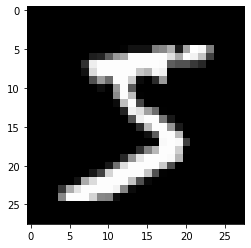

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch usa ``torch.tensor``, en lugar de matrices numpy, por lo que necesitamos convertir nuestros datos.

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Red neuronal desde cero (sin torch.nn)

Primero creemos un modelo usando nada más que operaciones de tensor de PyTorch.

PyTorch proporciona métodos para crear tensores llenos de cero o aleatorios, que usaremos para crear nuestros pesos y sesgos para un modelo lineal simple. Estos son solo tensores regulares, con una adición muy especial: le decimos a PyTorch que requieren un gradiente. Esto hace que PyTorch registre todas las operaciones realizadas en el tensor, de modo que pueda calcular el gradiente durante la retropropagación automáticamente.

Para los pesos, los configuramos ``requires_grad`` **después** de la inicialización, ya que no queremos que ese paso se incluya en el gradiente. (Tenga en cuenta que un final _ en PyTorch significa que la operación se realiza en el lugar).

 > **Nota**: Estamos inicializando los pesos aquí con la [inicialización de Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) (multiplicando por 1/sqrt(n)).

In [6]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Gracias a la capacidad de PyTorch para calcular gradientes automáticamente, podemos usar cualquier función estándar de Python (u objeto invocable) como modelo. Así que escribamos una multiplicación de matriz simple y una suma transmitida para crear un modelo lineal simple. También necesitamos una función de activación, así que escribiremos ``log_softmax`` y la usaremos. Recuerde: aunque PyTorch proporciona muchas funciones de pérdida preescritas, funciones de activación, etc., puede escribir fácilmente las suyas propias usando Python simple. PyTorch incluso creará código de GPU rápido o de CPU vectorizado para su función automáticamente.

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

En lo anterior, ``@`` representa la operación del producto escalar. Llamaremos a nuestra función en un lote de datos (en este caso, 64 imágenes). Este es un *forward pass*. Tenga en cuenta que nuestras predicciones no serán mejores que las aleatorias en esta etapa, ya que comenzamos con pesos aleatorios.

In [8]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.6717, -1.8259, -2.0875, -2.6154, -2.6661, -2.1858, -2.6514, -2.1348,
        -2.2511, -2.3368], grad_fn=<SelectBackward>) torch.Size([64, 10])


Como puede ver, el tensor ``preds`` contiene no solo los valores del tensor, sino también una función de gradiente. Usaremos esto más tarde para hacer backprop.

Implementemos una probabilidad de registro negativa para usarla como función de pérdida (nuevamente, podemos usar Python estándar):

In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Comprobemos nuestra pérdida con nuestro modelo aleatorio, para que podamos ver si mejoramos después de un pase de backprop más tarde.

In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3309, grad_fn=<NegBackward>)


Implementemos también una función para calcular la precisión de nuestro modelo. Para cada predicción, si el índice con el valor más grande coincide con el valor objetivo, entonces la predicción fue correcta.

In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

Comprobemos la precisión de nuestro modelo aleatorio, para que podamos ver si nuestra precisión mejora a medida que mejora nuestra pérdida.

In [12]:
print(accuracy(preds, yb))

tensor(0.0312)


Ahora podemos ejecutar un ciclo de entrenamiento. Para cada iteración, haremos lo siguiente:

 * seleccione un mini-lote de datos (de tamaño ``bs``)
 * usar el modelo para hacer predicciones
 * calcular la perdida
 * loss.backward() actualiza los gradientes del modelo, en este caso, ``weights`` y ``bias``.


Ahora usamos estos gradientes para actualizar los ``weights`` y ``bias``. Hacemos esto dentro del administrador de contexto ``torch.no_grad()``, porque no queremos que estas acciones se registren para nuestro próximo cálculo del gradiente. Puede leer más sobre cómo PyTorch's Autograd registra las operaciones [aquí](https://pytorch.org/docs/stable/notes/autograd.html).

Luego, establecemos los gradientes en cero, de modo que estemos listos para el siguiente ciclo. De lo contrario, nuestros gradientes registrarían un recuento de todas las operaciones que habían sucedido (es decir, ``loss.backward()`` agregarían los gradientes a lo que ya esté almacenado, en lugar de reemplazarlos).

 > **Tip**:
 > Puede usar el depurador de Python estándar para recorrer el código PyTorch, lo que le permite verificar los distintos valores de las variables en cada paso. Descomenta ``set_trace()`` a continuación para probarlo.

In [13]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

Eso es todo: hemos creado y entrenado una red neuronal mínima (en este caso, una regresión logística, ya que no tenemos capas ocultas) ¡completamente desde cero!

Comprobemos la pérdida y la precisión y comparémoslas con lo que obtuvimos antes. Esperamos que la pérdida haya disminuido y la precisión haya aumentado, y lo han hecho.

In [14]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0797, grad_fn=<NegBackward>) tensor(1.)


## Usando torch.nn

Ahora refactorizaremos nuestro código, para que haga lo mismo que antes, solo que comenzaremos a aprovechar las clases de PyTorch ``nn`` para hacerlo más conciso y flexible. En cada paso a partir de aquí, deberíamos hacer nuestro código uno o más de: más corto, más comprensible y/o más flexible.

El primer paso y el más fácil es acortar nuestro código reemplazando nuestras funciones de activación y pérdida escritas a mano por las de ``torch.nn.functional`` (que generalmente se importa al espacio de nombres ``F`` por convención). Este módulo contiene todas las funciones de la biblioteca ``torch.nn`` (mientras que otras partes de la biblioteca contienen clases). Además de una amplia gama de funciones de pérdida y activación, también encontrará aquí algunas funciones convenientes para crear redes neuronales, como las funciones de agrupación. (También hay funciones para hacer convoluciones, capas lineales, etc., pero como veremos, generalmente se manejan mejor usando otras partes de la biblioteca).

Si está utilizando una pérdida de probabilidad de registro negativa y una activación de softmax de registro, entonces Pytorch proporciona una única función ``F.cross_entropy`` que combina los dos. Así que incluso podemos eliminar la función de activación de nuestro modelo.

In [15]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

Tenga en cuenta que ya no llamamos a ``log_softmax`` en la función model. Confirmemos que nuestra pérdida y precisión son las mismas que antes:

In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0797, grad_fn=<NllLossBackward>) tensor(1.)


## Refactorizar usando nn.Module

A continuación, usaremos ``nn.Module`` y ``nn.Parameter``, para un ciclo de entrenamiento más claro y conciso. Hacemos una subclase ``nn.Module`` (que en sí misma es una clase y es capaz de realizar un seguimiento del estado). En este caso, queremos crear una clase que contenga nuestros pesos, sesgo y método para el forward step. ``nn.Module`` tiene una serie de atributos y métodos (como ``.parameters()`` y ``.zero_grad()``) que usaremos.

 > **Nota**:
 > ``nn.Module`` (M mayúscula) es un concepto específico de PyTorch, y es una clase que usaremos mucho. ``nn.Module`` no debe confundirse con el concepto de Python de un [module](https://docs.python.org/3/tutorial/modules.html) (en minúsculas m) , que es un archivo de código Python que se puede importar.

In [17]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

Dado que ahora estamos usando un objeto en lugar de solo usar una función, primero tenemos que crear una instancia de nuestro modelo:

In [18]:
model = Mnist_Logistic()

Ahora podemos calcular la pérdida de la misma forma que antes. Tenga en cuenta que los objetos ``nn.Module`` se utilizan como si fueran funciones (es decir, son *invocables*), pero detrás de escena Pytorch llamará a nuestro método ``forward`` automáticamente.

In [19]:
print(loss_func(model(xb), yb))

tensor(2.4979, grad_fn=<NllLossBackward>)


Anteriormente, para nuestro ciclo de entrenamiento, teníamos que actualizar los valores para cada parámetro por nombre y poner a cero manualmente los grados de cada parámetro por separado, así:

```python
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```

Ahora podemos aprovechar ``model.parameters()`` y ``model.zero_grad()`` (ambos definidos por PyTorch para ``nn.Module``) para hacer esos pasos más concisos y menos propensos al error de olvidar algunos de nuestros parámetros, particularmente si tuviéramos un modelo más complicado:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

Envolveremos nuestro pequeño ciclo de entrenamiento en una función ``fit`` para que podamos ejecutarlo de nuevo más tarde.

In [20]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Comprobemos dos veces que nuestra pérdida ha disminuido:

In [21]:
print(loss_func(model(xb), yb))

tensor(0.0837, grad_fn=<NllLossBackward>)


## Refactorizar usando nn.Lineal

Seguimos refactorizando nuestro código. En lugar de definir e inicializar manualmente ``self.weights`` y ``self.bias``, y calcular ``xb@self.weights + self.bias``, usaremos la clase [``nn.Linear``](https://pytorch.org/docs/stable/nn.html#linear-layers) de Pytorch para una capa lineal, que hace todo eso por nosotros. Pytorch tiene muchos tipos de capas predefinidas que pueden simplificar enormemente nuestro código y, a menudo, también lo hacen más rápido

In [22]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

Instanciamos nuestro modelo y calculamos la pérdida de la misma manera que antes:

In [23]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3060, grad_fn=<NllLossBackward>)


Todavía podemos usar nuestro mismo método ``fit`` igual que antes.

In [24]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0801, grad_fn=<NllLossBackward>)


## Refactorizar usando optim

Pytorch también tiene un paquete con varios algoritmos de optimización, ``torch.optim``. Podemos usar el método ``step`` de nuestro optimizador para dar un paso adelante, en lugar de actualizar manualmente cada parámetro.

Esto nos permitirá reemplazar nuestro anterior paso de optimización codificado manualmente:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

y en su lugar use solo:

```python
opt.step()
opt.zero_grad()
```

(``optim.zero_grad()`` restablece el gradiente a 0 y debemos llamarlo antes de calcular el gradiente para el siguiente minibatch).

In [25]:
from torch import optim

Definiremos una pequeña función para crear nuestro modelo y optimizador para que podamos reutilizarlo en el futuro.

In [26]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3182, grad_fn=<NllLossBackward>)
tensor(0.0814, grad_fn=<NllLossBackward>)


## Refactorizar usando Dataset

PyTorch tiene una clase de conjunto de datos abstracta. Un conjunto de datos puede ser cualquier cosa que tenga una función ``__len__`` (llamada por la lenfunción estándar de Python) y una función ``__getitem__`` como una forma de indexarlo. Este [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) muestra un buen ejemplo de cómo crear una clase ``FacialLandmarkDataset`` personalizada como una subclase de ``Dataset``.

[``TensorDataset``](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset) de PyTorch es un conjunto de datos que envuelve tensores. Al definir una longitud y una forma de indexar, esto también nos da una forma de iterar, indexar y cortar a lo largo de la primera dimensión de un tensor. Esto facilitará el acceso tanto a las variables independientes como a las dependientes en la misma línea mientras entrenamos.

In [27]:
from torch.utils.data import TensorDataset

Ambos ``x_train`` y ``y_train`` se pueden combinar en uno solo ``TensorDataset``, lo que será más fácil de iterar y cortar.

In [28]:
train_ds = TensorDataset(x_train, y_train)

Anteriormente, teníamos que iterar a través de minibatches de valores x e y por separado:

```python
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]
```

Ahora, podemos hacer estos dos pasos juntos:

```python
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]
```

xb,yb = train_ds[i*bs : i*bs+bs]

In [29]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward>)


## Refactorizar usando DataLoader

``DataLoaderes`` es responsable de administrar los lotes. Puede crear un ``DataLoader`` desde cualquier ``Dataset``. ``DataLoader`` facilita la iteración sobre lotes. En lugar de tener que usar ``train_ds[i*bs : i*bs+bs]``, ``DataLoader`` nos entrega cada minibatch automáticamente

In [30]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

Anteriormente, nuestro ciclo iteraba sobre lotes (xb, yb) como este:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
```

Ahora, nuestro bucle es mucho más limpio, ya que (xb, yb) se cargan automáticamente desde el cargador de datos:

```python
for xb,yb in train_dl:
    pred = model(xb)
```

In [31]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0814, grad_fn=<NllLossBackward>)


Gracias a ``nn.Module``, ``nn.Parameter``, ``Dataset``, y ``DataLoader``, nuestro bucle de entrenamiento es ahora dramáticamente más pequeño y más fácil de entender. Intentemos ahora agregar las características básicas necesarias para crear modelos efectivos en la práctica.

## Agregar validación

En la sección 1, solo estábamos tratando de configurar un ciclo de entrenamiento razonable para usar en nuestros datos de entrenamiento. En realidad, **siempre** debe tener un conjunto de validación para identificar si está sobreajustado.

Mezclar los datos de entrenamiento es [importante](https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks) para evitar la correlación entre lotes y el sobreajuste. Por otro lado, la pérdida de validación será idéntica tanto si barajamos el conjunto de validación como si no. Dado que barajar lleva más tiempo, no tiene sentido barajar los datos de validación.

Usaremos un tamaño de lote para el conjunto de validación que es dos veces más grande que el del conjunto de entrenamiento. Esto se debe a que el conjunto de validación no necesita backpropagation y, por lo tanto, requiere menos memoria (no necesita almacenar los gradientes). Aprovechamos esto para usar un tamaño de lote más grande y calcular la pérdida más rápidamente.

In [32]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

Calcularemos e imprimiremos la pérdida de validación al final de cada época.

(Tenga en cuenta que siempre llamamos a ``model.train()`` antes del entrenamiento y a ``model.eval()`` antes de la inferencia, porque estos son utilizados por capas como ``nn.BatchNorm2d`` y ``nn.Dropout`` para garantizar un comportamiento apropiado para estas diferentes fases).

In [33]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3714)
1 tensor(0.2934)


## Crear fit() y get_data()

Ahora haremos una pequeña refactorización por nuestra cuenta. Dado que pasamos por un proceso similar dos veces para calcular la pérdida tanto para el conjunto de entrenamiento como para el conjunto de validación, hagamos eso en su propia función ``loss_batch``, que calcula la pérdida para un lote.

Pasamos un optimizador para el conjunto de entrenamiento y lo usamos para realizar backprop. Para el conjunto de validación, no pasamos un optimizador, por lo que el método no realiza backprop.

In [34]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

``fit`` ejecuta las operaciones necesarias para entrenar nuestro modelo y calcular las pérdidas de entrenamiento y validación para cada época.

In [35]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

``get_data`` devuelve cargadores de datos para los conjuntos de entrenamiento y validación.

In [36]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Ahora, todo nuestro proceso de obtención de los cargadores de datos y ajuste del modelo se puede ejecutar en 3 líneas de código:

In [37]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.6188143182277679
1 0.31489434183835985


Puede utilizar estas 3 líneas básicas de código para entrenar una amplia variedad de modelos. ¡Veamos si podemos usarlos para entrenar una red neuronal convolucional (CNN)!

## Cambiar a una CNN

Ahora vamos a construir nuestra red neuronal con tres capas convolucionales. Debido a que ninguna de las funciones de la sección anterior asume nada sobre el formulario del modelo, podremos usarlas para entrenar una CNN sin ninguna modificación.

Usaremos la clase [``Conv2d``](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) predefinida de Pytorch como nuestra capa convolucional. Definimos una CNN con 3 capas convolucionales. Cada convolución va seguida de un ReLU. Al final, realizamos un pooling promedio. (Tenga en cuenta que ``view`` es la versión de PyTorch de numpy ``reshape``)

In [38]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

[``Momentum``](https://cs231n.github.io/neural-networks-3/#sgd) es una variación del descenso de gradiente estocástico que también tiene en cuenta las actualizaciones anteriores y, por lo general, conduce a un entrenamiento más rápido.

In [39]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36609563262462613
1 0.2646807765483856


## nn.Sequential

``torch.nn`` tiene otra clase útil que podemos usar para simplificar nuestro código: [``Sequential``](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential). Un objeto ``Sequential`` ejecuta cada uno de los módulos que contiene, de forma secuencial. Esta es una forma más sencilla de escribir nuestra red neuronal.

Para aprovechar esto, necesitamos poder definir fácilmente una **capa personalizada** a partir de una función determinada. Por ejemplo, PyTorch no tiene una capa de vista y necesitamos crear una para nuestra red. ``Lambda`` creará una capa que luego podremos usar al definir una red con ``Sequential``.

In [40]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

El modelo creado con ``Sequential`` es simplemente:

In [41]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3352325009584427
1 0.2778443576335907


## Envolviendo con DataLoader

Nuestra CNN es bastante concisa, pero solo funciona con MNIST, porque:
 * Se asume que la entrada es un vector de tipo long de 28*28
 * Se asume que el tamaño final de la cuadrícula de CNN es 4*4 (ya que ese es el promedio
agrupando el tamaño del grano que usamos)

Vamos a deshacernos de estos dos supuestos, por lo que nuestro modelo funciona con cualquier imagen 2d de un solo canal. Primero, podemos eliminar la capa Lambda inicial moviendo el preprocesamiento de datos a un generador:

In [42]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

A continuación, podemos reemplazar ``nn.AvgPool2d`` con ``nn.AdaptiveAvgPool2d``, lo que nos permite definir el tamaño del tensor de salida que queremos, en lugar del tensor de entrada que tenemos. Como resultado, nuestro modelo funcionará con cualquier tamaño de entrada.

In [43]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Probémoslo:

In [44]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.32772532162666324
1 0.25251343932151793


## Usando tu GPU

Si tiene la suerte de tener acceso a una GPU compatible con CUDA (puede alquilar una por aproximadamente $0.50/hora en la mayoría de los proveedores de la nube), puede usarla para acelerar su código. Primero verifique que su GPU esté funcionando en Pytorch:

In [45]:
print(torch.cuda.is_available())

True


Y luego crea un objeto de dispositivo para él:

In [46]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Actualicemos ``preprocess`` para mover lotes a la GPU:

In [47]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Finalmente, podemos mover nuestro modelo a la GPU.

In [48]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Debería encontrar que corre más rápido ahora:

In [49]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.24973450191020966
1 0.18176193383932113


## Resumen

Ahora tenemos una canalización de datos general y un ciclo de entrenamiento que puede usar para entrenar muchos tipos de modelos usando Pytorch. Para ver qué tan simple puede ser el entrenamiento de un modelo ahora, eche un vistazo al cuaderno de muestra ``mnist_sample``.

Por supuesto, hay muchas cosas que querrá agregar, como aumento de datos, ajuste de hiperparámetros, entrenamiento de monitoreo, aprendizaje de transferencia, etc. Estas funciones están disponibles en la biblioteca fastai, que se ha desarrollado utilizando el mismo enfoque de diseño que se muestra en este tutorial, lo que proporciona un siguiente paso natural para los profesionales que buscan llevar sus modelos más lejos.

Prometimos al comienzo de este tutorial nos gustaría explicar a través del ejemplo de cada uno ``torch.nn``, ``torch.optim``, ``Dataset``, y ``DataLoader``. Así que resumamos lo que hemos visto:

 - **torch.nn**

   + ``Module``: crea un invocable que se comporta como una función, pero también puede contener estados (como pesos de capa de red neuronal). Sabe que ``Parameter`` contiene y puede poner a cero todos sus gradientes, recorrerlos para actualizaciones de pesos, etc.
   + ``Parameter``: un contenedor para un tensor que le dice a a ``Module`` que tiene pesos que necesitan actualizarse durante backprop. Solamente los tensores con el atributo ``requires_grad`` se actualizan
   + ``functional``: un módulo (generalmente importado al ``F`` espacio de nombres por convención) que contiene funciones de activación, funciones de pérdida, etc., así como versiones sin estado de capas, como capas convolucionales y lineales.
 - ``torch.optim``: Contiene optimizadores como ``SGD``, que actualizan los pesos de ``Parameter`` durante el backward step
   of ``Parameter`` during the backward step
 - ``Dataset``: Una interfaz abstracta de objetos con como ``__len__`` y ``__getitem__``, incluidas las clases proporcionadas con Pytorch como ``TensorDataset``
 - ``DataLoader``: Toma cualquiera ``Dataset`` y crea un iterador que devuelve lotes de datos.

